In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

General information:
folder 1, OD, post-trial 2

In [2]:
path_to_hpc = r"D:\OS_Basic\Rat_3\OD\post_trial2_2017-11-16_12-14-17\HPC_100_CH15.continuous.mat"
path_to_pfc = r"D:\OS_Basic\Rat_3\OD\post_trial2_2017-11-16_12-14-17\PFC_100_CH49.continuous.mat"
path_to_states = r"D:\OS_Basic\Rat_3\OD\post_trial2_2017-11-16_12-14-17\post_trial2_2017-11-16_12-14-17-states.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

In [3]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

There was 0 in the dataset
There was 0 in the dataset


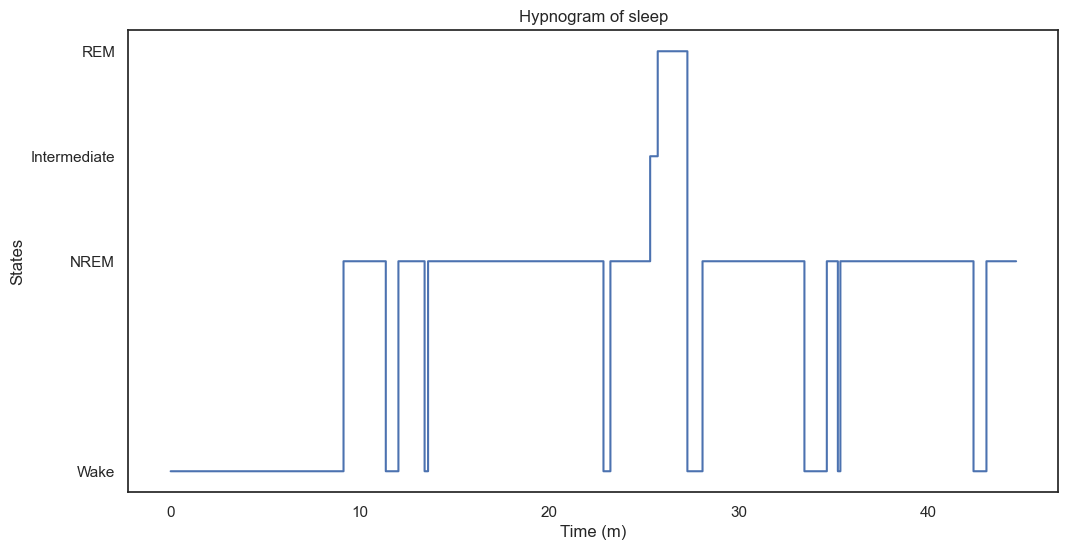

In [4]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)
plot_hypnogram(hypno)

In [5]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [6]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [7]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intervals:2
Number of detected Tonic intervals after threshold:2


1

In [8]:
print([phasic_interval])

[  index    start      end
      0   1605.1  1606.37
shape: (1, 2), time unit: sec.]


In [9]:
print([tonic_interval])

[  index    start     end
      0  1545     1605.1
      1  1606.37  1638
shape: (2, 2), time unit: sec.]


In [10]:
interval7 = np.arange(1606.49, 1638.0, 4)
print(interval7)

[1606.49 1610.49 1614.49 1618.49 1622.49 1626.49 1630.49 1634.49]


In [11]:
tonic_time = np.array([[1545.0, 1549.], [1549., 1553.], [1553., 1557.], [1557., 1561.], [1561., 1565.], [1565., 1569.], [1569., 1573.], [1573., 1577.],
                       [1577., 1581.], [1581., 1585.], [1585., 1589.], [1589., 1593.], [1593., 1597.], [1597., 1601.], [1601., 1605.11], [1606.49, 1610.49],
                       [1610.49, 1614.49], [1614.49, 1618.49], [1618.49, 1622.49], [1622.49, 1626.49], [1626.49, 1630.49], [1630.49, 1634.49], [1634.49, 1638.0]]
                     )
print(tonic_time.size)

46


In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [13]:
for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    print(signal1.size)

10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10004
10279
10004
10004
10004
10004
10004
10004
10004
8779


In [14]:
highsize = 10279

## Comparison

## Coherence

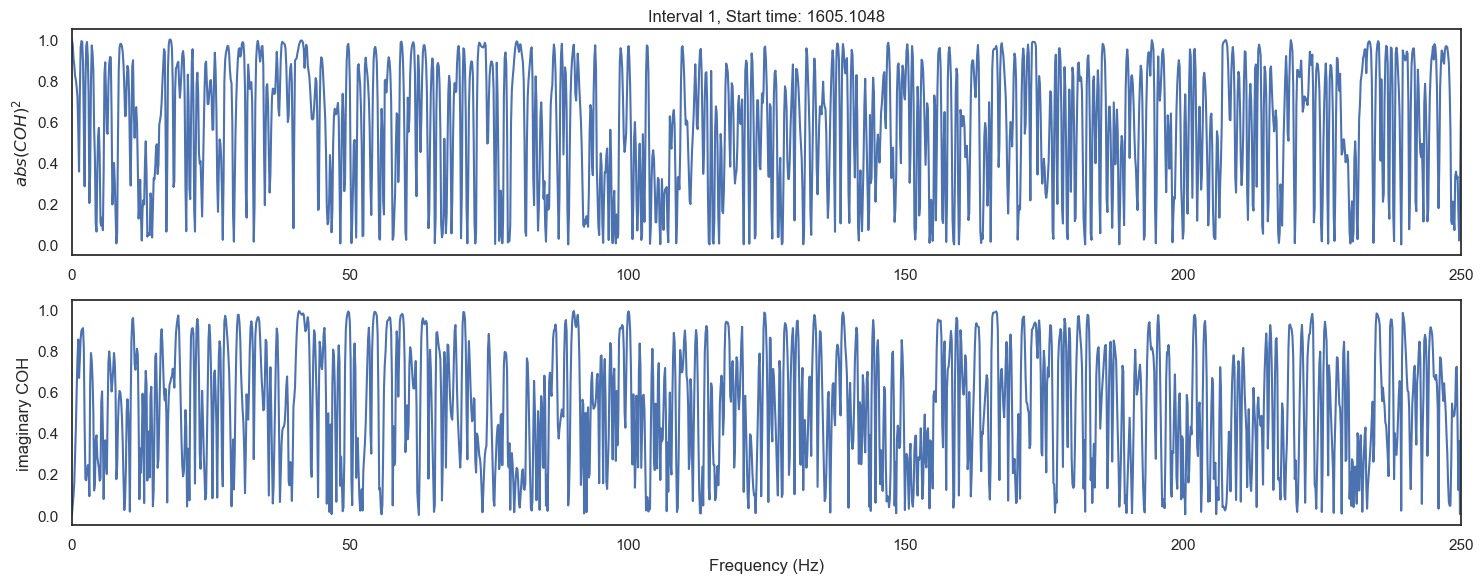

In [15]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('imaginary COH')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_coh_R3T2.png")

mean coh: 0.6475742215440208 +/- 0.0030569981455213367
mean icoh: 0.5043314111368001 +/- 0.003048334375289313
mean coh: 0.5412331590078139 +/- 0.0032959458118668634
mean icoh: 0.49255926883481266 +/- 0.0026773413795424085
mean coh: 0.5611973616776074 +/- 0.003367649103815177
mean icoh: 0.5656431577532803 +/- 0.002633191845963828
mean coh: 0.5729883227677475 +/- 0.0032896340034222612
mean icoh: 0.5402222333768781 +/- 0.0031410089496169257


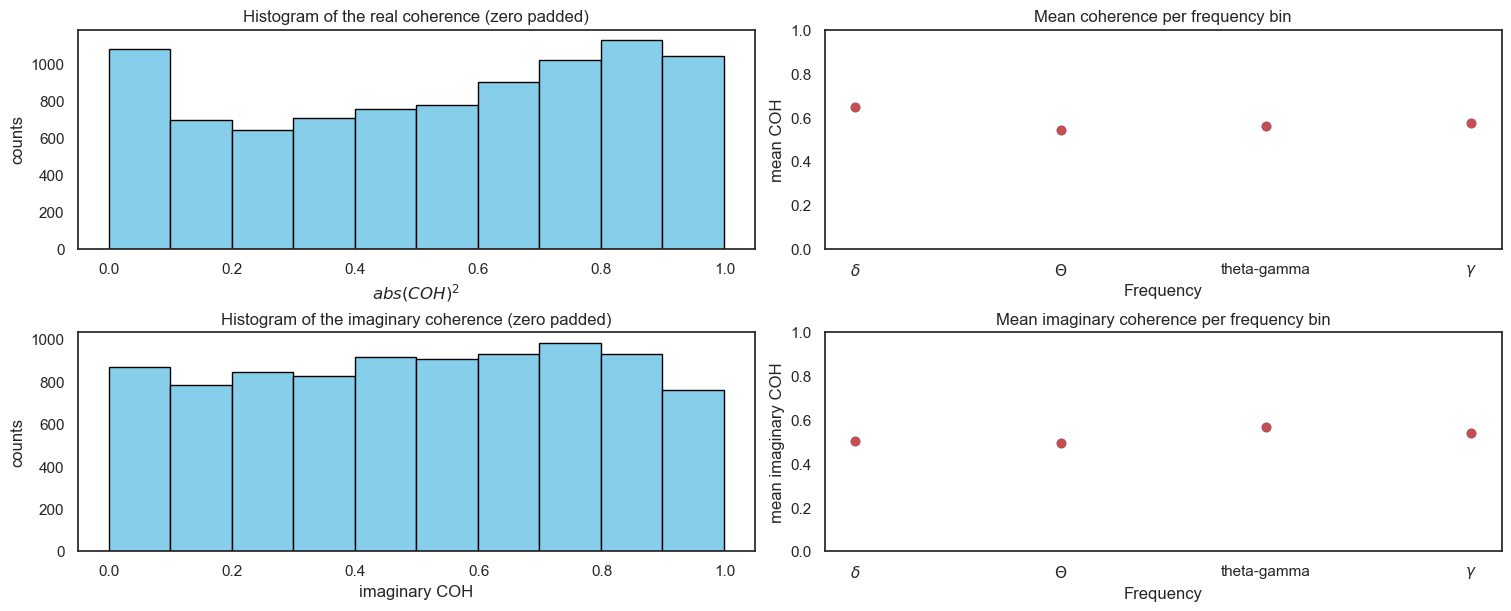

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$', '$\Theta$', 'theta-gamma', '$\gamma$']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_phasic = bin_means
mean_icoh_phasic = bin_means2
SEM_coh_phasic = error
SEM_icoh_phasic = error2

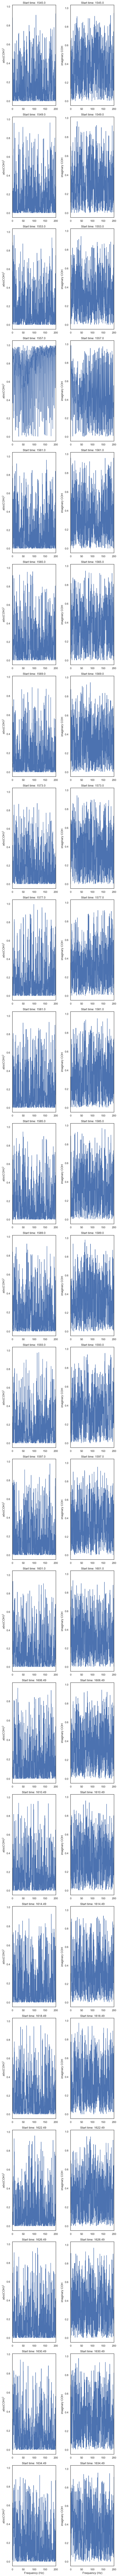

In [17]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 150), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    
    axes[i, 0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i,0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i,1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('imaginary COH')

axes[22,0].set_xlabel('Frequency (Hz)')
axes[22,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_coh_R3T2.png")

mean coh: 0.2180296749880409 +/- 0.000703346570685666
mean coh: 0.28289863882310073 +/- 0.0007517453762961462
mean coh: 0.2034731301483565 +/- 0.0006450841776730144
mean coh: 0.1939407811835688 +/- 0.0006544202277498571
mean icoh: 0.35267902414477886 +/- 0.0006518738302739857
mean icoh: 0.34555284246023654 +/- 0.0006752825481159858
mean icoh: 0.3584613593597437 +/- 0.0006372530439981291
mean icoh: 0.3486028563985736 +/- 0.0006497212418878844


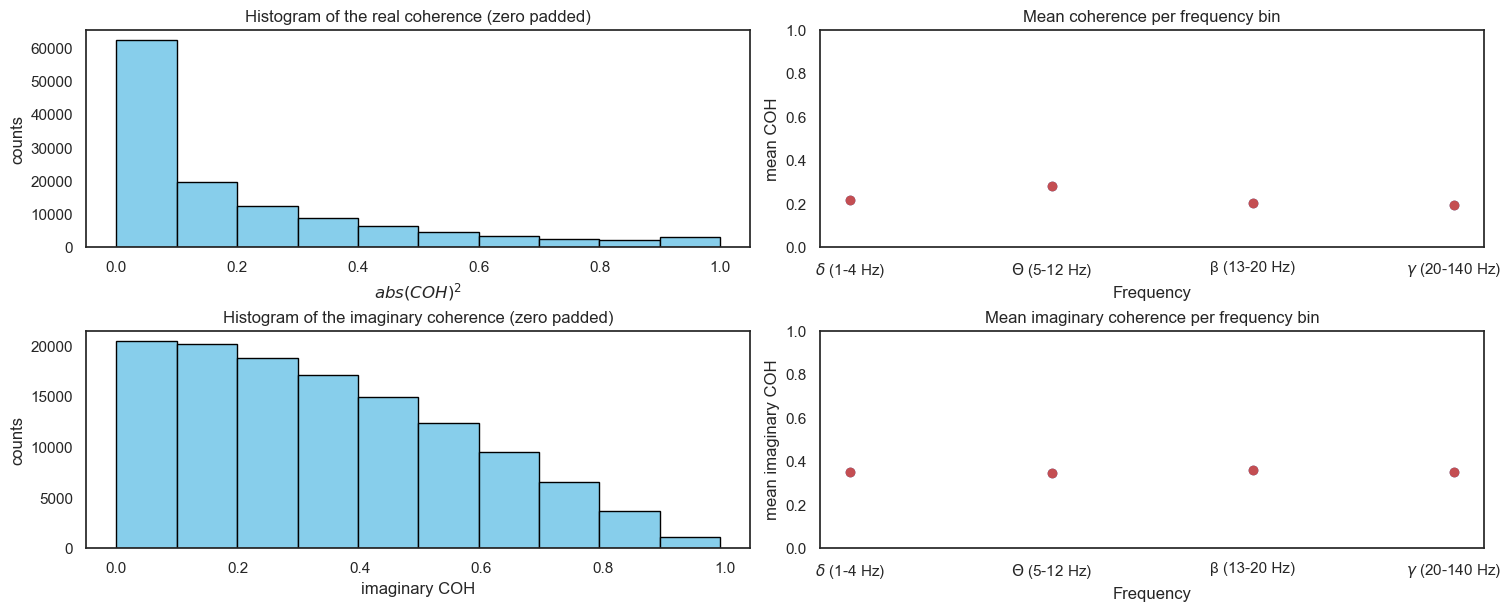

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_tonic = bin_means
mean_icoh_tonic = bin_means2
SEM_coh_tonic = error
SEM_icoh_tonic = error2

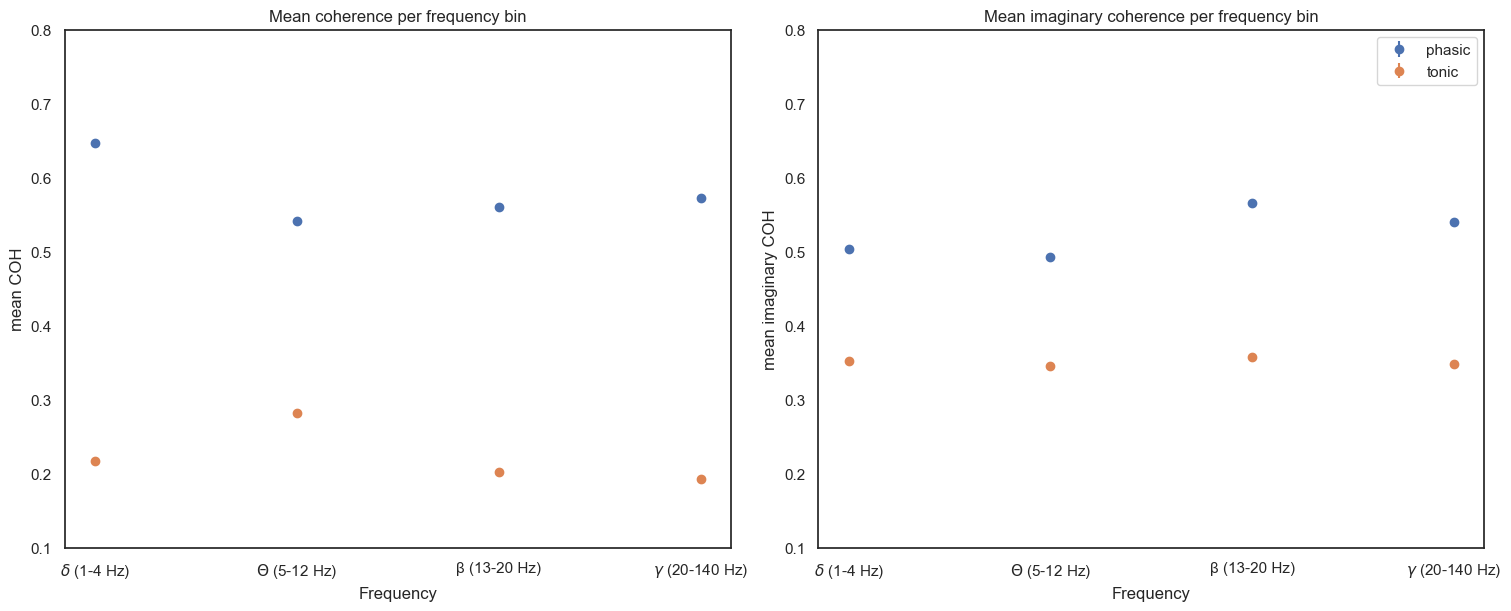

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_coh_phasic, yerr=SEM_coh_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_coh_tonic, yerr=SEM_coh_tonic, fmt="o", label='tonic')
axes[0].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean COH')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean coherence per frequency bin')

axes[1].errorbar(frequency_type, mean_icoh_phasic, yerr=SEM_icoh_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_icoh_tonic, yerr=SEM_icoh_tonic, fmt="o", label='tonic')
axes[1].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean imaginary COH')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean imaginary coherence per frequency bin')
plt.legend()

## Phase lag index

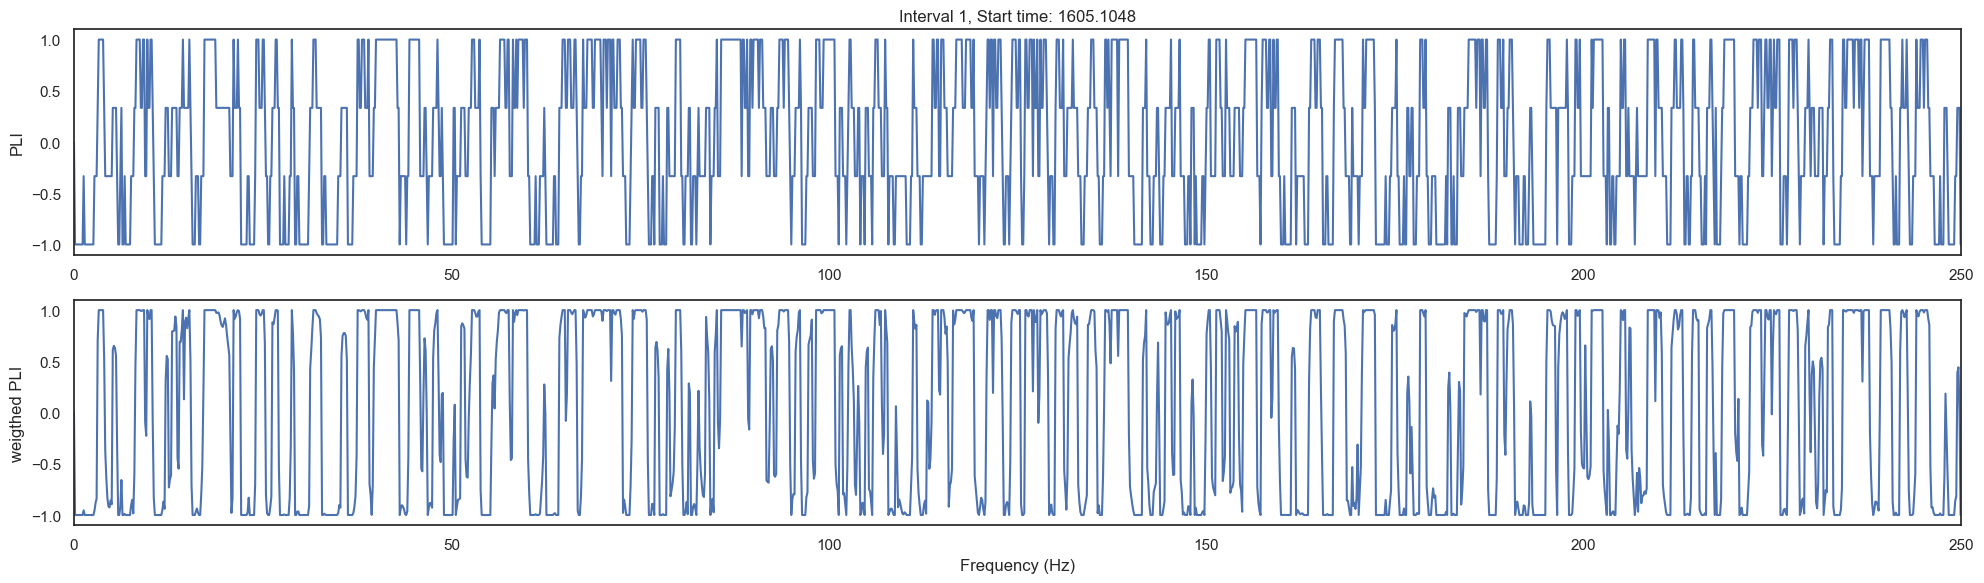

In [20]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_pli_R3T2.png")

mean pli: -0.30952380952380965 +/- 0.0077338754361686475
mean pli: -0.13095238095238096 +/- 0.007490185484001849
mean pli: 0.2517006802721089 +/- 0.00654107079150777
mean pli: 0.12142857142857137 +/- 0.007691543066328913
mean wpli: -0.4624443583763552 +/- 0.008520215642818527
mean wpli: -0.21371619294485564 +/- 0.008943652577549248
mean wpli: 0.4114130663477203 +/- 0.008323433739465569
mean wpli: 0.14746419859196067 +/- 0.009359932812812572


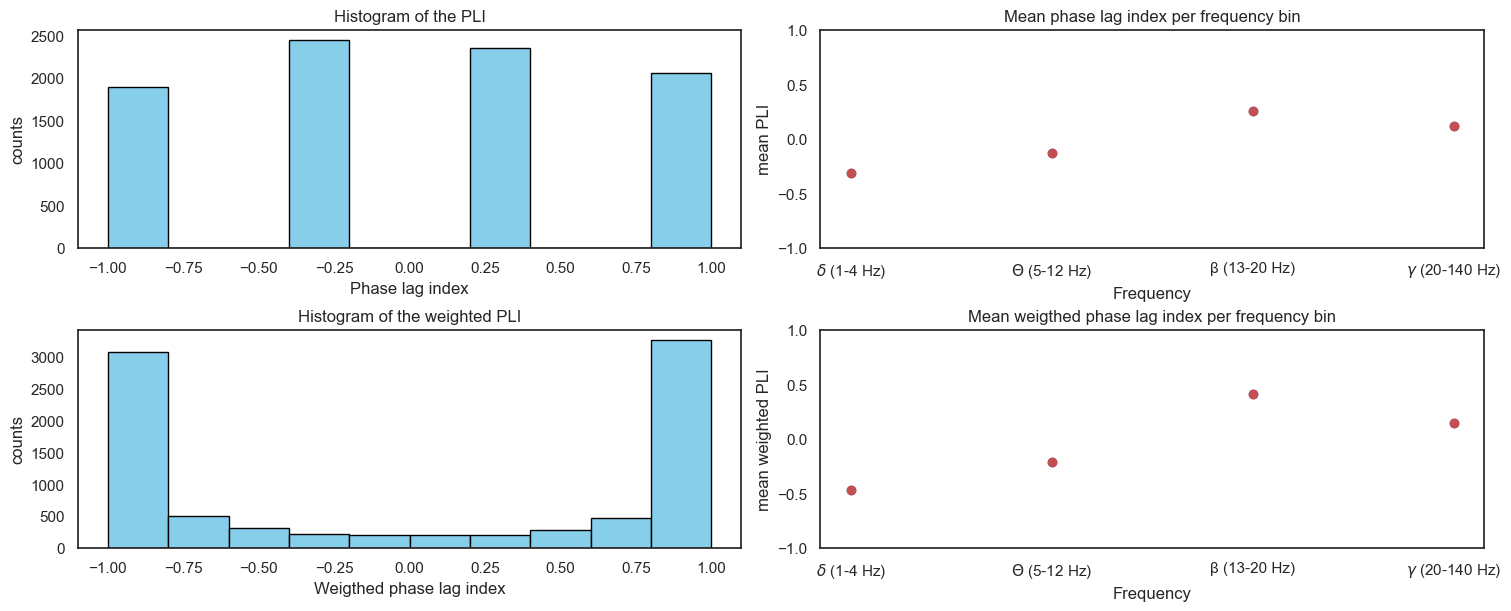

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_pli_phasic = bin_means
mean_wpli_phasic = bin_means2
SEM_pli_phasic = error
SEM_wpli_phasic = error2

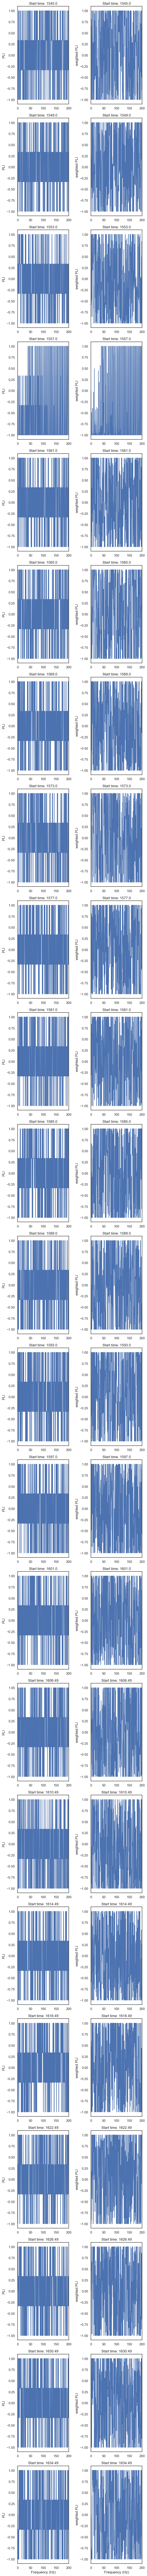

In [22]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7,120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted PLI')

axes[22,0].set_xlabel('Frequency (Hz)')
axes[22,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_pli_R3T2.png")

mean pli: -0.035714285714285754 +/- 0.0017141616779728825
mean pli: 0.11854605534902928 +/- 0.0016901894679494844
mean pli: 0.046242774566473986 +/- 0.0017016309397831647
mean pli: -0.010457625700660785 +/- 0.0016841337005754555
mean wpli: -0.06248898385897804 +/- 0.0020488610455880484
mean wpli: 0.18787911169503244 +/- 0.0020071392807650707
mean wpli: 0.08642838715492797 +/- 0.0020739068736085656
mean wpli: -0.005959477246233625 +/- 0.0020503399937116962


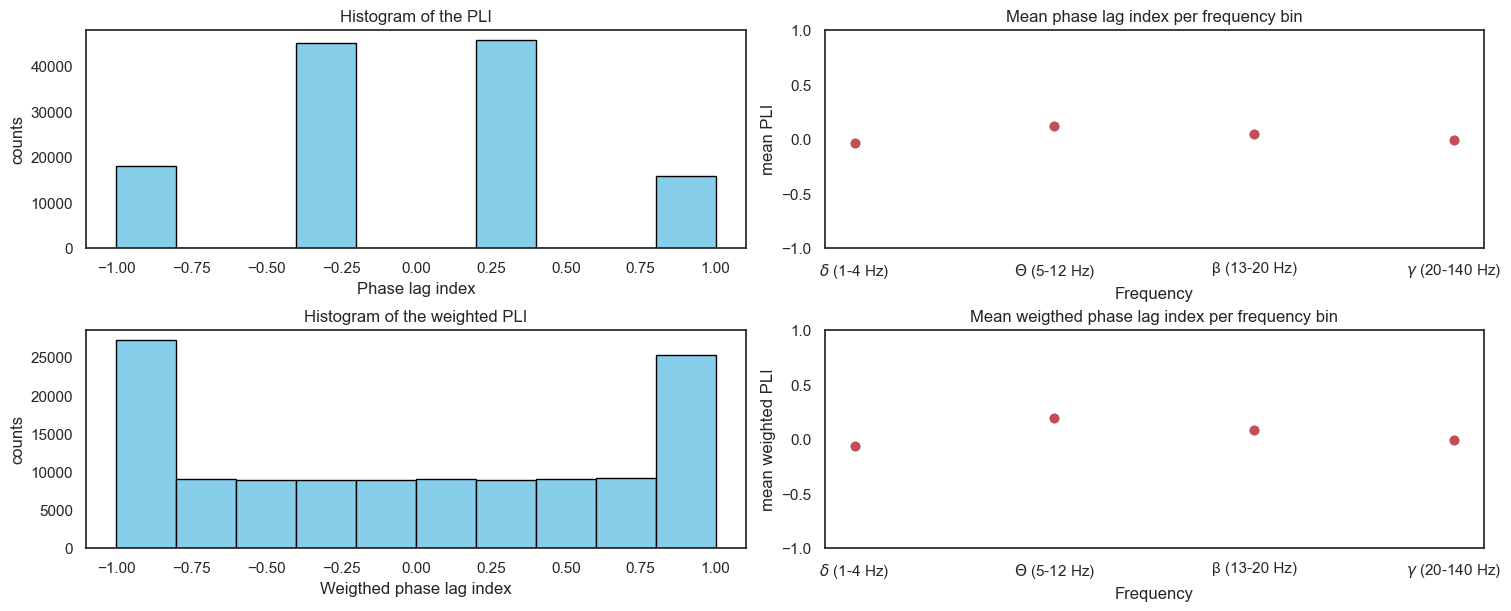

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_pli_tonic = bin_means
mean_wpli_tonic = bin_means2
SEM_pli_tonic = error
SEM_wpli_tonic = error2

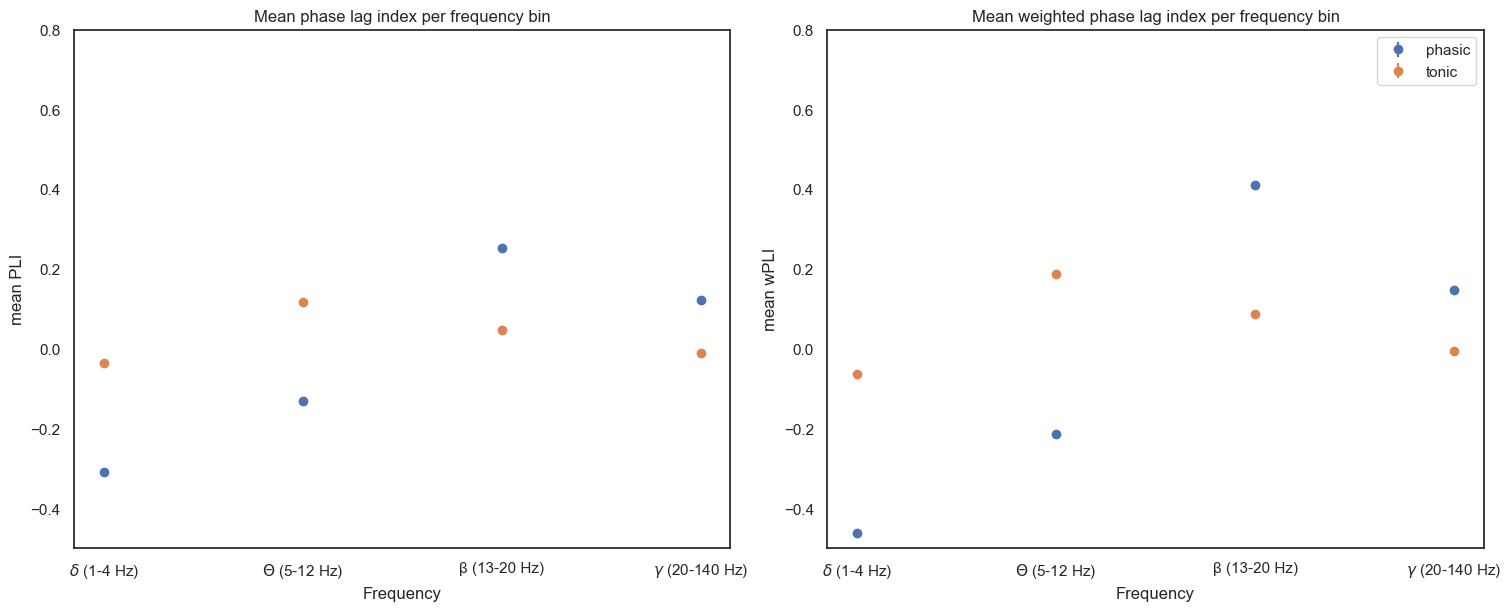

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_pli_phasic, yerr=SEM_pli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_pli_tonic, yerr=SEM_pli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean PLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean phase lag index per frequency bin')

axes[1].errorbar(frequency_type, mean_wpli_phasic, yerr=SEM_wpli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wpli_tonic, yerr=SEM_wpli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted phase lag index per frequency bin')
plt.legend()

## Debiased squared PLI

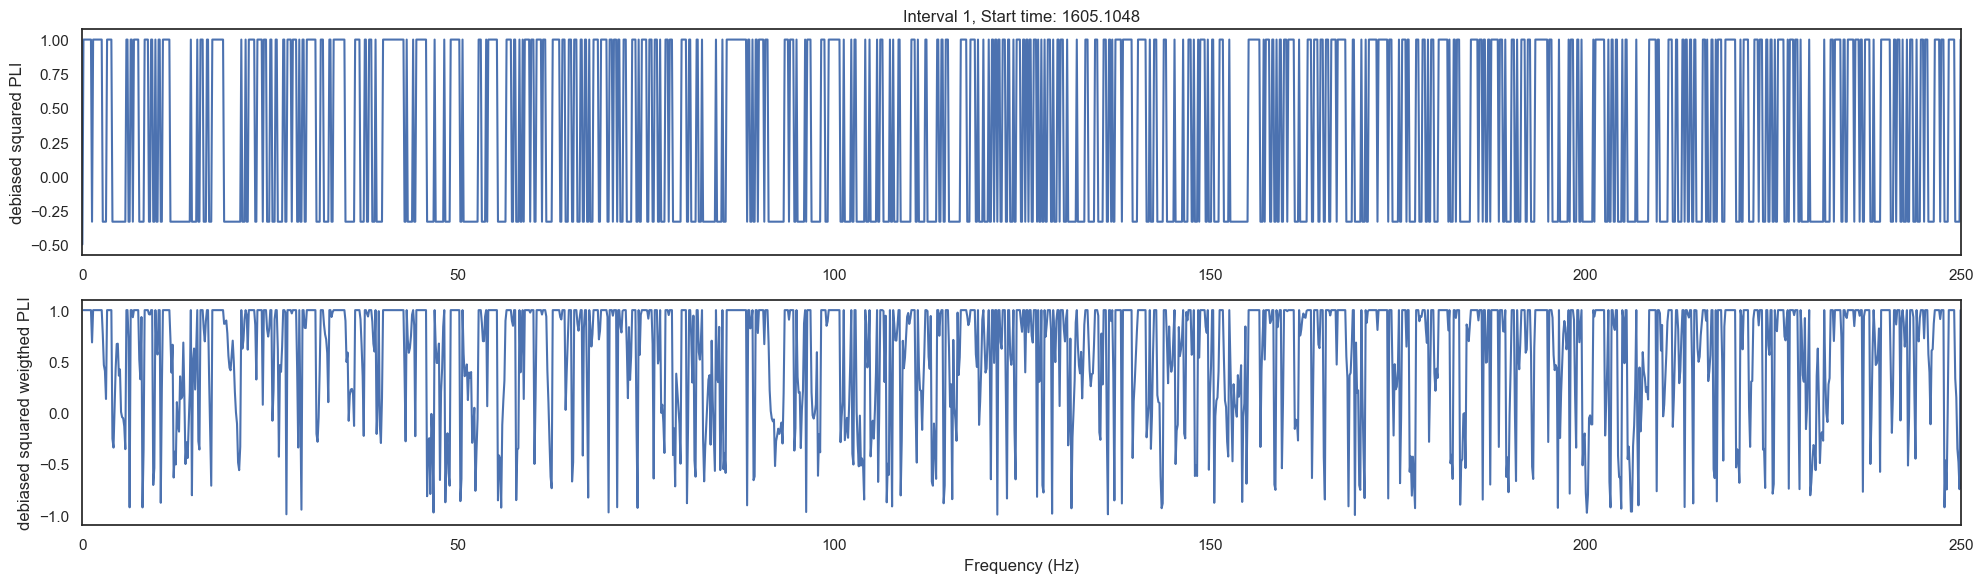

In [25]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[0].set_xlim((0, 250))
    axes[0].set_title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    #axes[0, i].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('debiased squared PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    axes[1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[1].set_xlim((0, 250))
    #axes[1, i].set_title(f"Interval {i+1}")
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('debiased squared weigthed PLI')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_dspli_R3T2.png")

mean dspli: 0.4285714285714283 +/- 0.007054673721340388
mean dspli: 0.2619047619047619 +/- 0.007086751000141797
mean dspli: 0.15646258503401347 +/- 0.006872351573185114
mean dspli: 0.2984126984126958 +/- 0.007117995909224561
mean wdspli: 0.7153578503606137 +/- 0.0042983330103675286
mean wdspli: 0.4877871950178942 +/- 0.006792602200080839
mean wdspli: 0.5323299484830954 +/- 0.005670101419133958
mean wdspli: 0.5704297560588082 +/- 0.006216334298955962


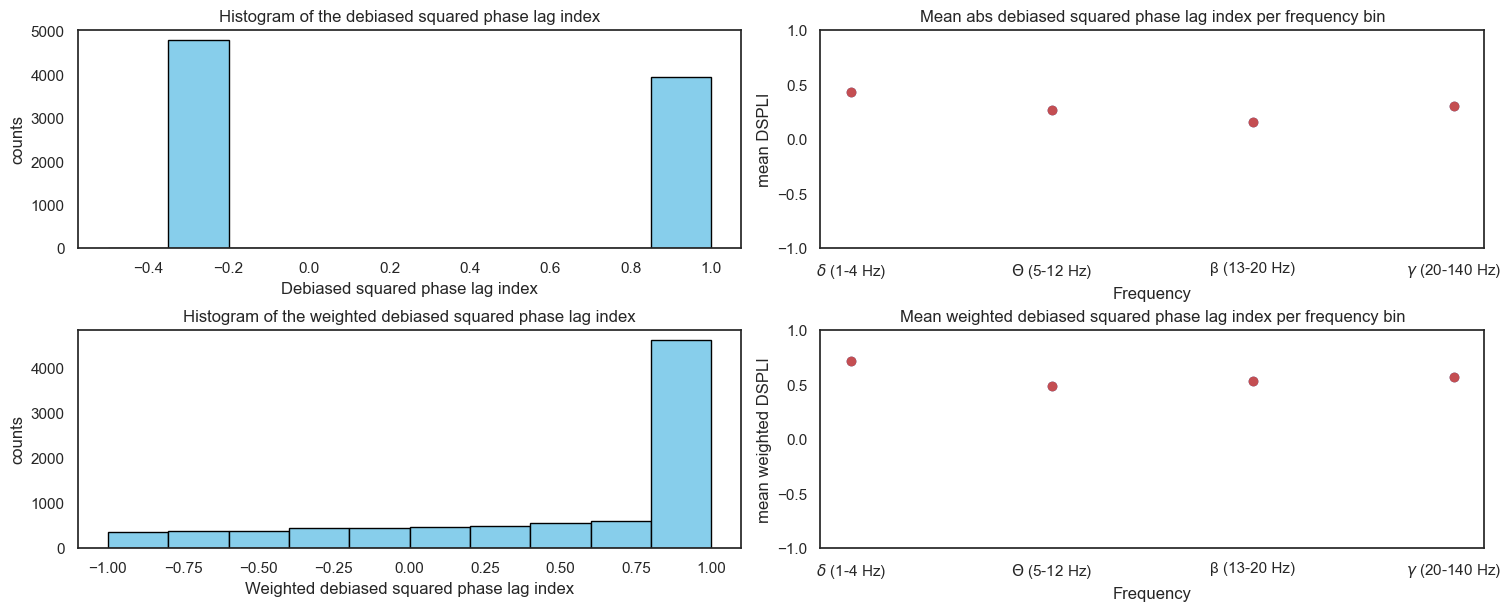

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_dspli_phasic = bin_means
mean_wdspli_phasic = bin_means2
SEM_dspli_phasic = error
SEM_wdspli_phasic = error2

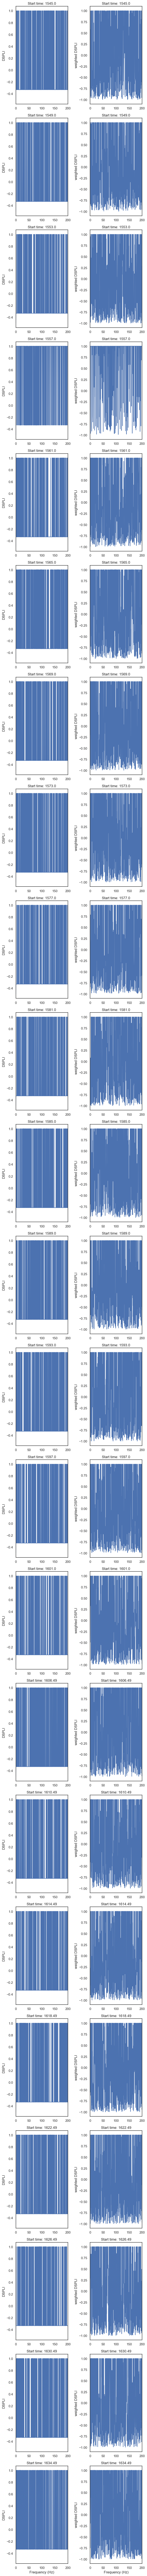

In [27]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
frequency_set2 = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(7, 120), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('DSPLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    frequency_set2 = np.append(frequency_set2,connectivity.frequencies)
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted DSPLI')

axes[22,0].set_xlabel('Frequency (Hz)')
axes[22,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_dspli_R3T2.png")

mean dspli: 0.05102040816326514 +/- 0.001711050618823313
mean dspli: 0.05493597686906201 +/- 0.0017161925490437383
mean dspli: 0.04431599229287146 +/- 0.0017020424238236645
mean dspli: 0.03020162302352036 +/- 0.0016822195659757946
mean wdspli: 0.04619212926479293 +/- 0.0021166839318495583
mean wdspli: 0.06331558498275633 +/- 0.0021642111391826486
mean wdspli: 0.07307559227841684 +/- 0.002099717075567966
mean wdspli: 0.04575941467620875 +/- 0.002098557505073222


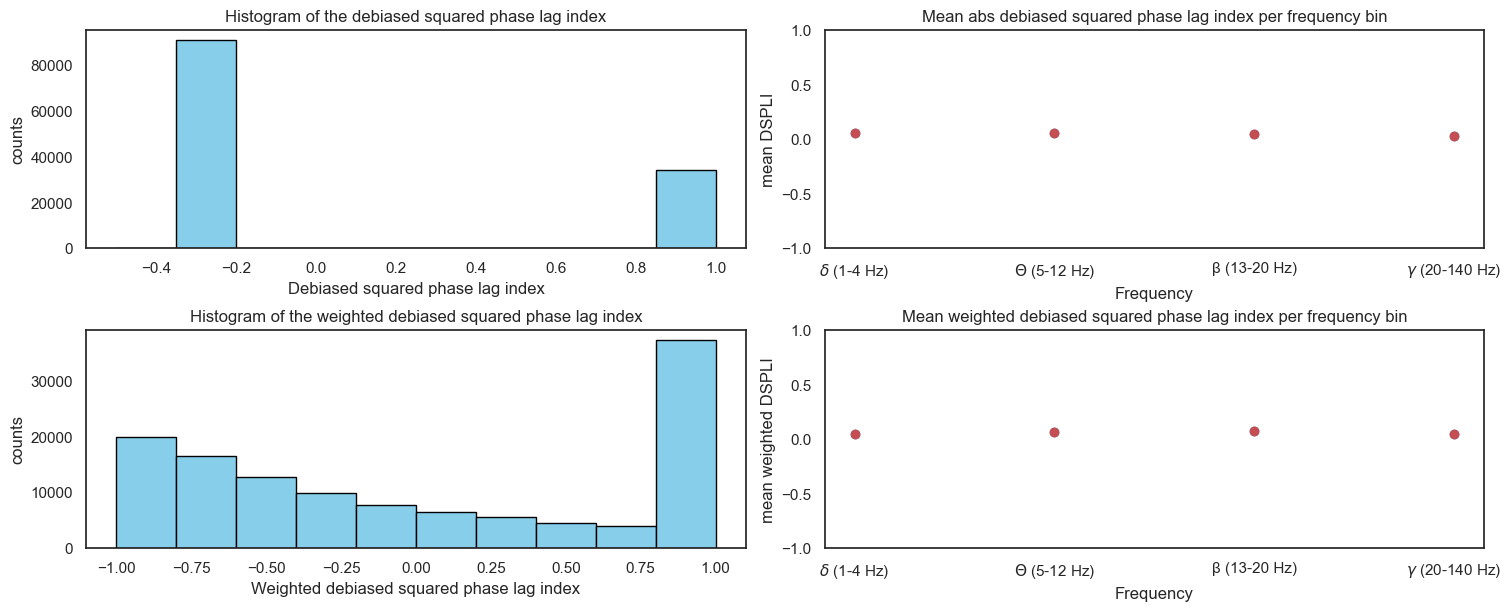

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_dspli_tonic = bin_means
mean_wdspli_tonic = bin_means2
SEM_dspli_tonic = error
SEM_wdspli_tonic = error2

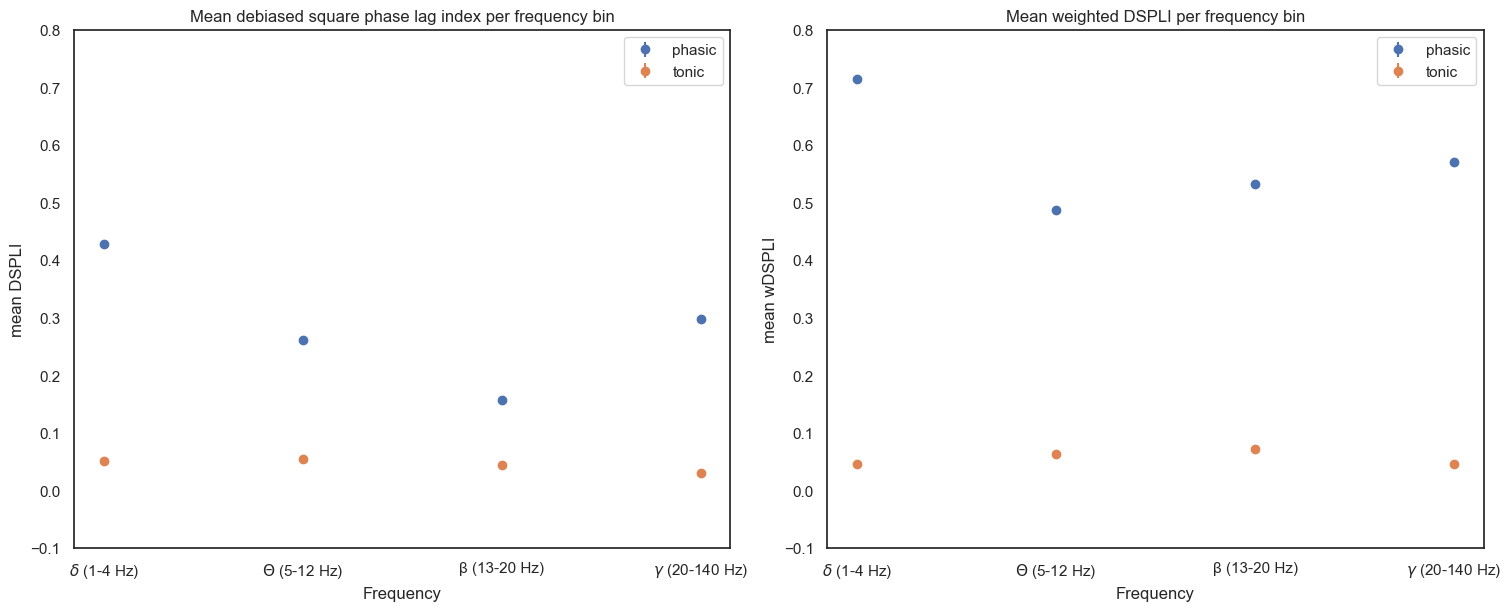

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_dspli_phasic, yerr=SEM_dspli_phasic, fmt="o", label='phasic')
axes[0].errorbar(frequency_type, mean_dspli_tonic, yerr=SEM_dspli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean DSPLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean debiased square phase lag index per frequency bin')
axes[0].legend()

axes[1].errorbar(frequency_type, mean_wdspli_phasic, yerr=SEM_wdspli_phasic, fmt="o", label='phasic')
axes[1].errorbar(frequency_type, mean_wdspli_tonic, yerr=SEM_wdspli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wDSPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted DSPLI per frequency bin')
plt.legend()

## Pairwise phase consistency

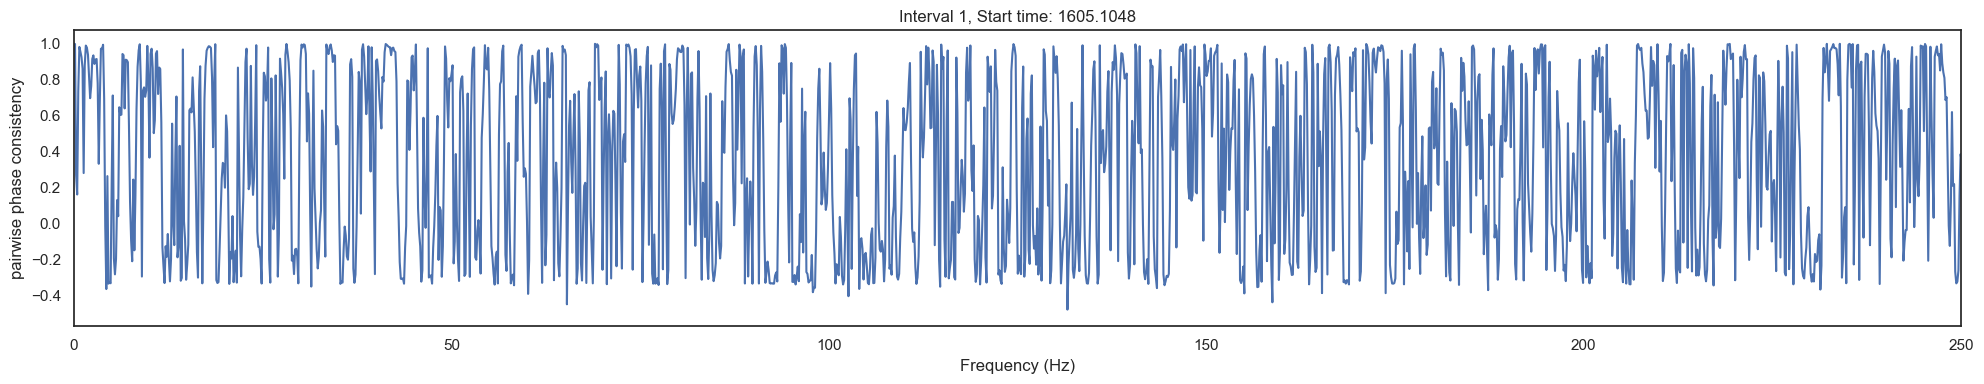

In [30]:
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), constrained_layout=True)

for i in range(len(phasic_interval)):
    interval_low = find_nearest(t, phasic_interval[i,0])
    index_low = np.where(t == interval_low)[0]
    
    interval_high = find_nearest(t, phasic_interval[i,1])
    index_high = np.where(t == interval_high)[0]

    signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[index_low[0]:index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    plt.plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    plt.xlim((0, 250))
    plt.title(f"Interval {i+1}, Start time: {phasic_interval[i,0]}")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('pairwise phase consistency')

fig.set_layout_engine(layout='tight')
fig.savefig("phasic_ppc_R3T2.png")

mean ppc: 0.6082980199762478 +/- 0.004907374127426952
mean ppc: 0.43272421624856083 +/- 0.004940169604870667
mean ppc: 0.3252099318799076 +/- 0.0049836456937952835
mean ppc: 0.3122773092531963 +/- 0.0051253854290214396


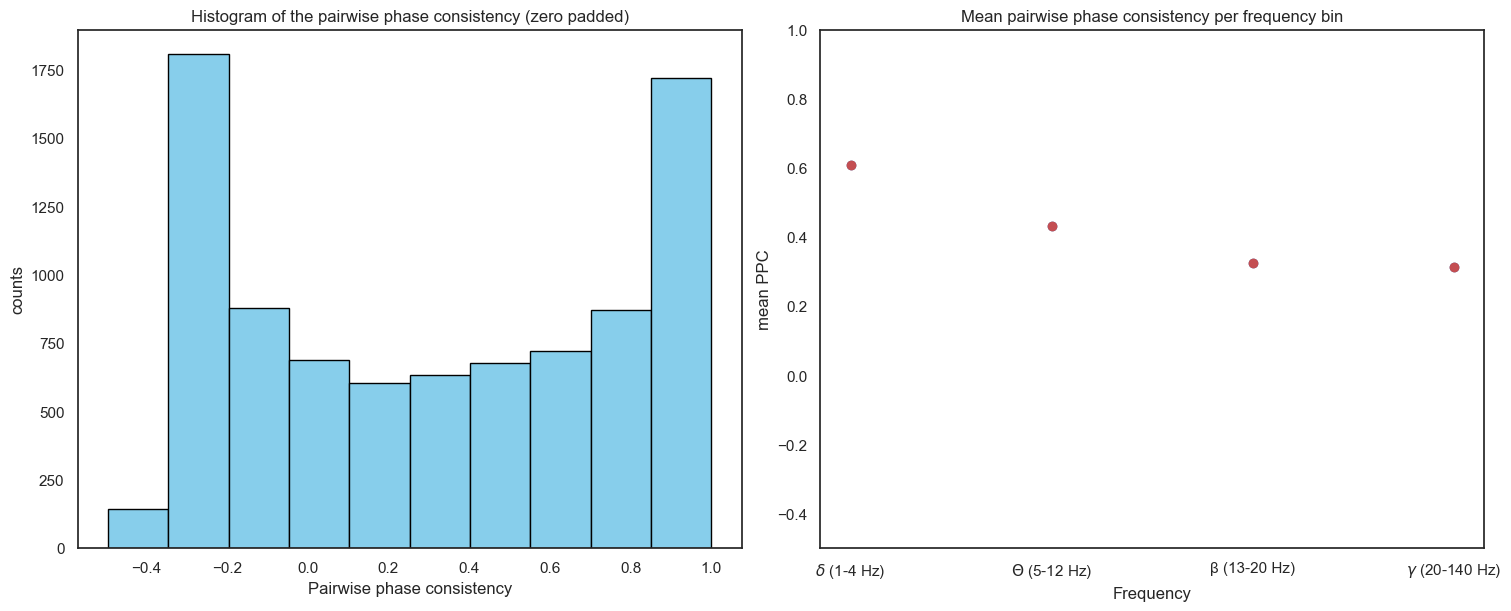

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

mean_ppc_phasic = bin_means
SEM_ppc_phasic = error

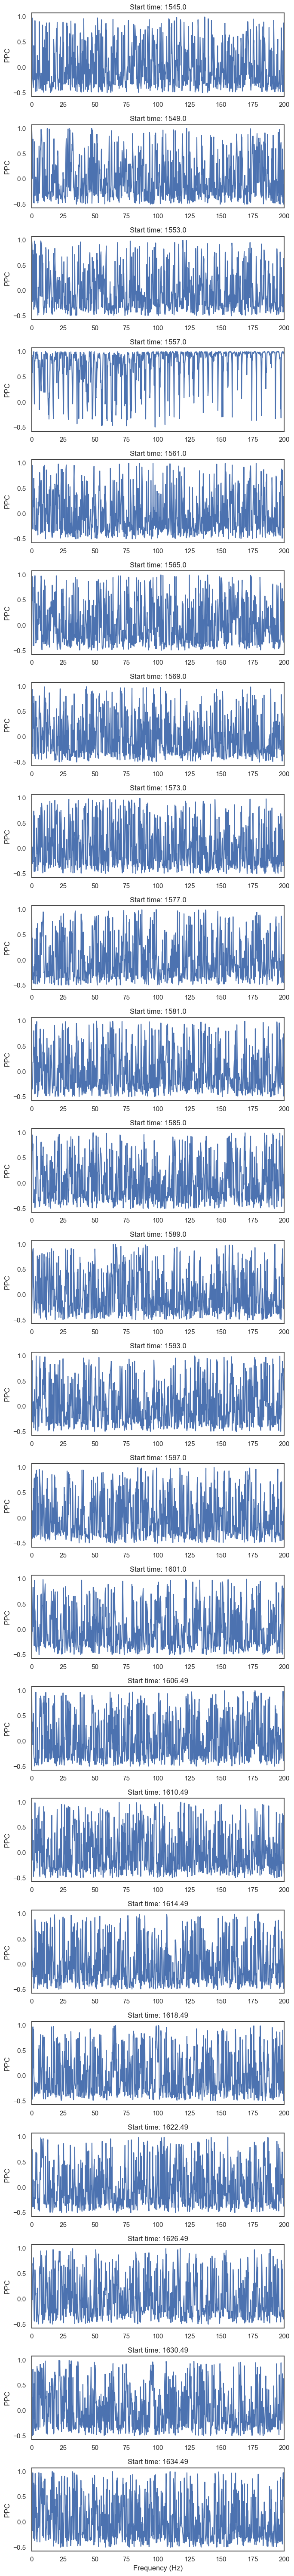

In [32]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=1, figsize=(7, 60), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[index_low[0]:index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 200))
    #axes[i].set_title(f"Interval {i+1}, real COH")
    axes[i].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PPC')

axes[22].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_ppc_R3T2.png")

mean ppc: 0.057573459909262124 +/- 0.0012744604849318736
mean ppc: 0.13456784309496894 +/- 0.0012868728626522202
mean ppc: 0.0455035138863317 +/- 0.0012004818462788352
mean ppc: 0.03680302753537451 +/- 0.0012274563128105963


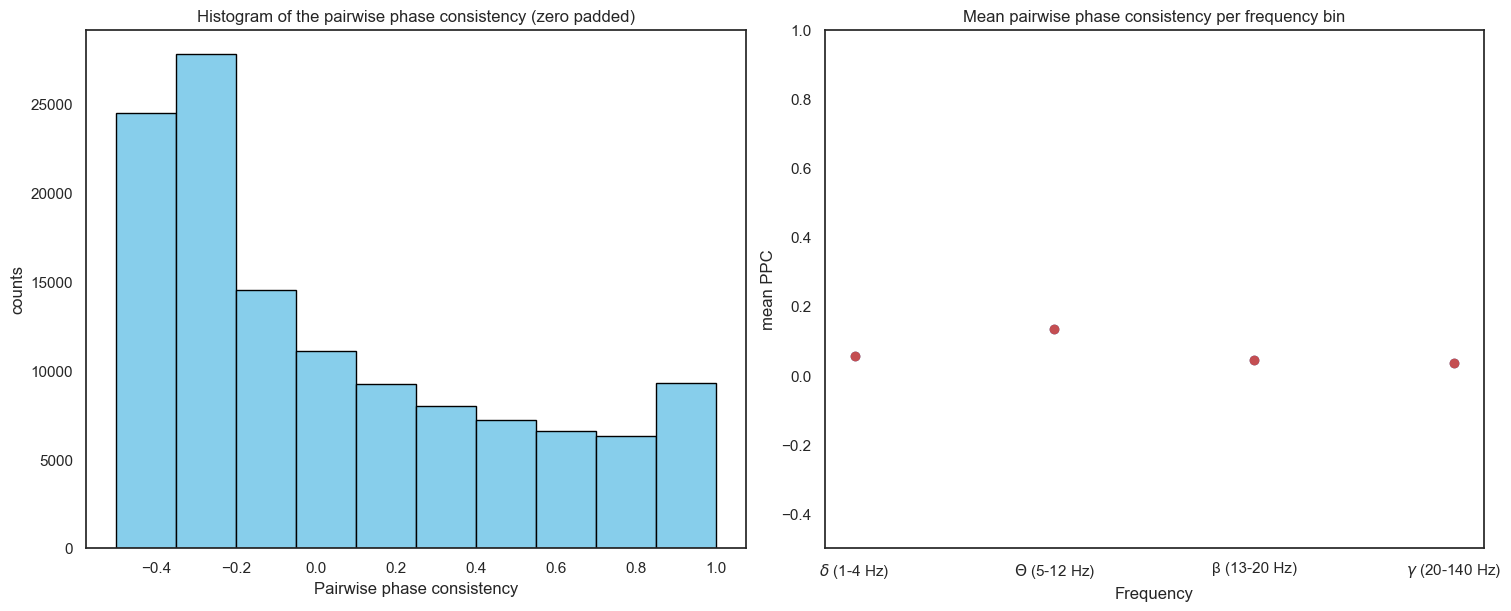

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_ppc_tonic = bin_means
SEM_ppc_tonic = error

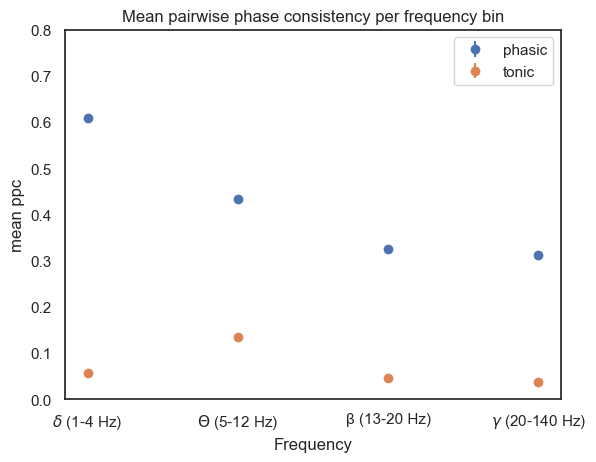

In [34]:
plt.errorbar(frequency_type, mean_ppc_phasic, yerr=SEM_ppc_phasic, fmt="o", label='phasic')
plt.errorbar(frequency_type, mean_ppc_tonic, yerr=SEM_ppc_tonic, fmt="o", label='tonic')
plt.ylim(0,0.8)
plt.ylabel('mean ppc')
plt.xlabel('Frequency')
plt.title('Mean pairwise phase consistency per frequency bin')
plt.legend()

## Table

In [35]:
mean_coh = np.hstack((mean_coh_phasic, mean_coh_tonic))
mean_icoh = np.hstack((mean_icoh_phasic, mean_icoh_tonic))
mean_pli = np.hstack((mean_pli_phasic, mean_pli_tonic))
mean_wpli = np.hstack((mean_wpli_phasic, mean_wpli_tonic))
mean_dspli = np.hstack((mean_dspli_phasic, mean_dspli_tonic))
mean_wdspli = np.hstack((mean_wdspli_phasic, mean_wdspli_tonic))
mean_ppc = np.hstack((mean_ppc_phasic, mean_ppc_tonic))

SEM_coh = np.hstack((SEM_coh_phasic, SEM_coh_tonic))
SEM_icoh = np.hstack((SEM_icoh_phasic, SEM_icoh_tonic))
SEM_pli = np.hstack((SEM_pli_phasic, SEM_pli_tonic))
SEM_wpli = np.hstack((SEM_wpli_phasic, SEM_wpli_tonic))
sem_dspli = np.hstack((SEM_dspli_phasic, SEM_dspli_tonic))
sem_wdspli = np.hstack((SEM_wdspli_phasic, SEM_wdspli_tonic))
SEM_ppc = np.hstack((SEM_ppc_phasic, SEM_ppc_tonic))

In [36]:
rows = []
for i in range(8):
    rows.append({
                    'COH': mean_coh[i],
                    'SE COH': SEM_coh[i],
                    'iCOH': mean_icoh[i],
                    'SE iCOH': SEM_icoh[i],
                    'PLI': mean_pli[i],
                    'SE PLI': SEM_pli[i],
                    'wPLI': mean_wpli[i],
                    'SE wPLI': SEM_wpli[i],
                    'DSPLI': mean_dspli[i],
                    'SE DSPLI': sem_dspli[i],
                    'wDSPLI': mean_wdspli[i],
                    'SE wDSPLI': sem_wdspli[i],
                    'PPC': mean_ppc[i],
                    'SE PPC': SEM_ppc[i]
                })
df = pd.DataFrame(rows, index = ["phasic delta", "phasic theta", "phasic theta-gamma", "phasic gamma", "tonic delta", "tonic theta", "tonic theta-gamma", "tonic gamma"])
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_R3T2_OD.csv', index=True)
df

COH    SE COH      iCOH   SE iCOH       PLI  \
phasic delta        0.647574  0.003057  0.504331  0.003048 -0.309524   
phasic theta        0.541233  0.003296  0.492559  0.002677 -0.130952   
phasic theta-gamma  0.561197  0.003368  0.565643  0.002633  0.251701   
phasic gamma        0.572988  0.003290  0.540222  0.003141  0.121429   
tonic delta         0.218030  0.000703  0.352679  0.000652 -0.035714   
tonic theta         0.282899  0.000752  0.345553  0.000675  0.118546   
tonic theta-gamma   0.203473  0.000645  0.358461  0.000637  0.046243   
tonic gamma         0.193941  0.000654  0.348603  0.000650 -0.010458   

                      SE PLI      wPLI   SE wPLI     DSPLI  SE DSPLI  \
phasic delta        0.007734 -0.462444  0.008520  0.428571  0.007055   
phasic theta        0.007490 -0.213716  0.008944  0.261905  0.007087   
phasic theta-gamma  0.006541  0.411413  0.008323  0.156463  0.006872   
phasic gamma        0.007692  0.147464  0.009360  0.298413  0.007118   
tonic delta         0.001714 -0.062489  0.002049  0.051020  0.001711   
tonic theta         0.001690  0.187879  0.002007  0.054936  0.001716   
tonic theta-gamma   0.001702  0.086428  0.002074  0.044316  0.001702   
tonic gamma         0.001684 -0.005959  0.002050  0.030202  0.001682   

                      wDSPLI  SE wDSPLI       PPC    SE PPC  
phasic delta        0.715358   0.004298  0.608298  0.004907  
phasic theta        0.487787   0.006793  0.432724  0.004940  
phasic theta-gamma  0.532330   0.005670  0.325210  0.004984  
phasic gamma        0.570430   0.006216  0.312277  0.005125  
tonic delta         0.046192   0.002117  0.057573  0.001274  
tonic theta         0.063316   0.002164  0.134568  0.001287  
tonic theta-gamma   0.073076   0.002100  0.045504  0.001200  
tonic gamma         0.045759   0.002099  0.036803  0.001227